# Support Vector Classifier

**Support Vector Classifier**: Support Vector Classifier (SVC), also known as Support Vector Machine (SVM), is a powerful machine learning algorithm used to solve classification problems. SVC is particularly effective for classifying non-linearly separable datasets and also performs well on high-dimensional datasets. The basic principle of the algorithm is to separate classes from each other by creating a decision boundary that best separates the data points.

# Import Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("display.width",500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, r2_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # Support Vector Classifier

!pip install joblib
import joblib

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6000,0.6270,50,1
1,1,85,66,29,0,26.6000,0.3510,31,0
2,8,183,64,0,0,23.3000,0.6720,32,1
3,1,89,66,23,94,28.1000,0.1670,21,0
4,0,137,40,35,168,43.1000,2.2880,33,1


# General Information About to the Dataset

In [5]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(df)

######################### Head #########################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.6000                    0.6270   50        1
1            1       85             66             29        0 26.6000                    0.3510   31        0
2            8      183             64              0        0 23.3000                    0.6720   32        1
3            1       89             66             23       94 28.1000                    0.1670   21        0
4            0      137             40             35      168 43.1000                    2.2880   33        1
######################### Tail #########################
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome
763           10      101             76             48      180 32.9000                    0.1710   63    

# Analysis of Categorical and Numerical Variables

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car, num_but_cat

In [8]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")
print(f"Num_But_Cat: {len(num_but_cat)}")

Observations: 768
Variables: 9
Cat_cols: 1
Num_cols: 8
Cat_but_car: 0
Num_But_Cat: 1


In [9]:
def cat_summary(dataframe,col_name,plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      'Ration': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("##########################################")
  if plot:
    sns.countplot(x=dataframe[col_name],data=dataframe)
    plt.show(block=True)

In [10]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in cat_cols:
    cat_summary(dataframe, col, plot=True)

         Outcome  Ration
Outcome                 
0            500 65.1042
1            268 34.8958
##########################################


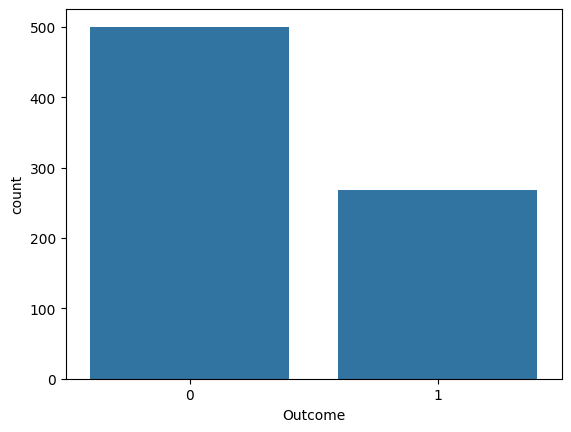

In [11]:
cat_summary_df(df)

In [12]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

In [13]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

count   768.0000
mean      3.8451
std       3.3696
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       1.0000
30%       1.0000
40%       2.0000
50%       3.0000
60%       4.0000
70%       5.0000
80%       7.0000
90%       9.0000
95%      10.0000
99%      13.0000
max      17.0000
Name: Pregnancies, dtype: float64


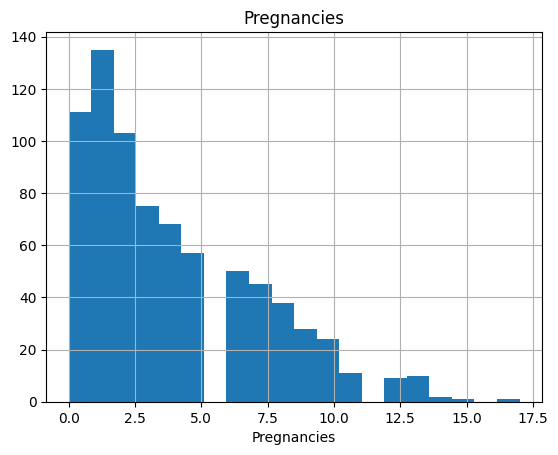

count   768.0000
mean    120.8945
std      31.9726
min       0.0000
1%       57.0000
5%       79.0000
10%      85.0000
20%      95.0000
30%     102.0000
40%     109.0000
50%     117.0000
60%     125.0000
70%     134.0000
80%     147.0000
90%     167.0000
95%     181.0000
99%     196.0000
max     199.0000
Name: Glucose, dtype: float64


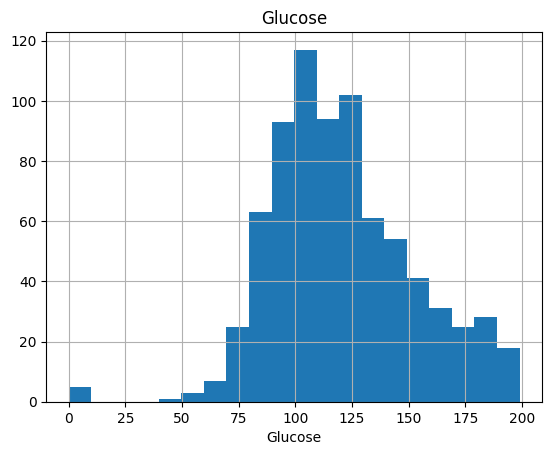

count   768.0000
mean     69.1055
std      19.3558
min       0.0000
1%        0.0000
5%       38.7000
10%      54.0000
20%      60.0000
30%      64.0000
40%      68.0000
50%      72.0000
60%      74.0000
70%      78.0000
80%      82.0000
90%      88.0000
95%      90.0000
99%     106.0000
max     122.0000
Name: BloodPressure, dtype: float64


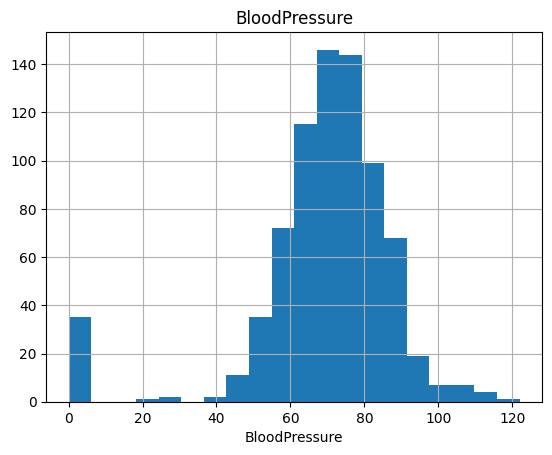

count   768.0000
mean     20.5365
std      15.9522
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       8.2000
40%      18.0000
50%      23.0000
60%      27.0000
70%      31.0000
80%      35.0000
90%      40.0000
95%      44.0000
99%      51.3300
max      99.0000
Name: SkinThickness, dtype: float64


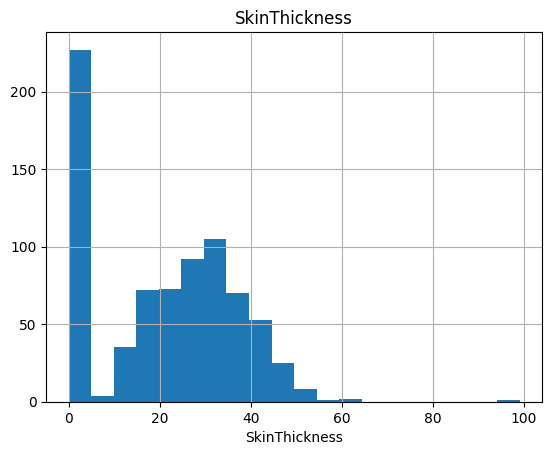

count   768.0000
mean     79.7995
std     115.2440
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       0.0000
40%       0.0000
50%      30.5000
60%      72.2000
70%     106.0000
80%     150.0000
90%     210.0000
95%     293.0000
99%     519.9000
max     846.0000
Name: Insulin, dtype: float64


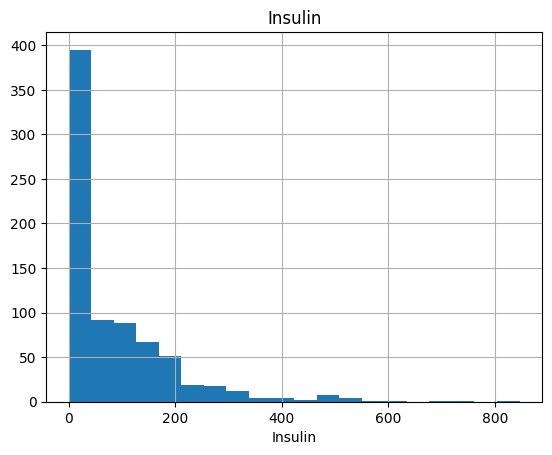

count   768.0000
mean     31.9926
std       7.8842
min       0.0000
1%        0.0000
5%       21.8000
10%      23.6000
20%      25.9000
30%      28.2000
40%      30.1000
50%      32.0000
60%      33.7000
70%      35.4900
80%      37.8000
90%      41.5000
95%      44.3950
99%      50.7590
max      67.1000
Name: BMI, dtype: float64


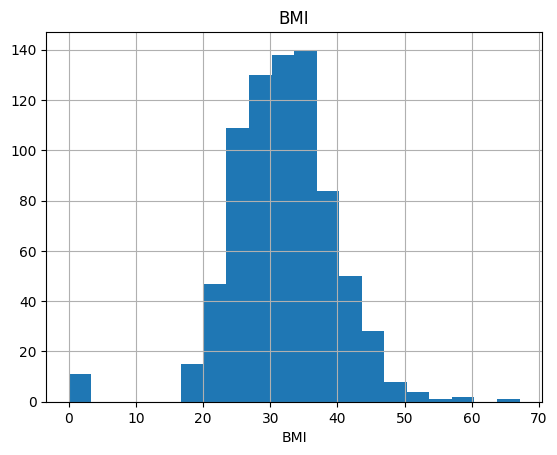

count   768.0000
mean      0.4719
std       0.3313
min       0.0780
1%        0.0947
5%        0.1404
10%       0.1650
20%       0.2194
30%       0.2590
40%       0.3028
50%       0.3725
60%       0.4542
70%       0.5637
80%       0.6870
90%       0.8786
95%       1.1328
99%       1.6983
max       2.4200
Name: DiabetesPedigreeFunction, dtype: float64


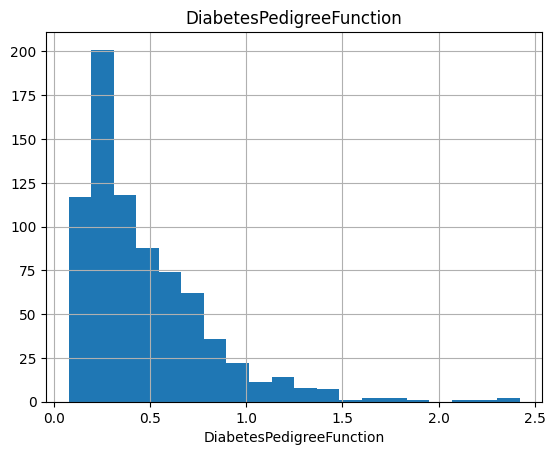

count   768.0000
mean     33.2409
std      11.7602
min      21.0000
1%       21.0000
5%       21.0000
10%      22.0000
20%      23.0000
30%      25.0000
40%      27.0000
50%      29.0000
60%      33.0000
70%      38.0000
80%      42.6000
90%      51.0000
95%      58.0000
99%      67.0000
max      81.0000
Name: Age, dtype: float64


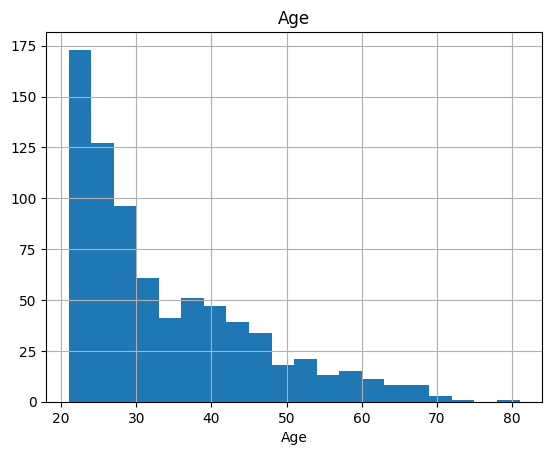

In [14]:
num_summary_df(df)

In [15]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  plt.figure(figsize=(12,8))
  for index, col in enumerate(num_cols):
    plt.subplot(3,3, index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)

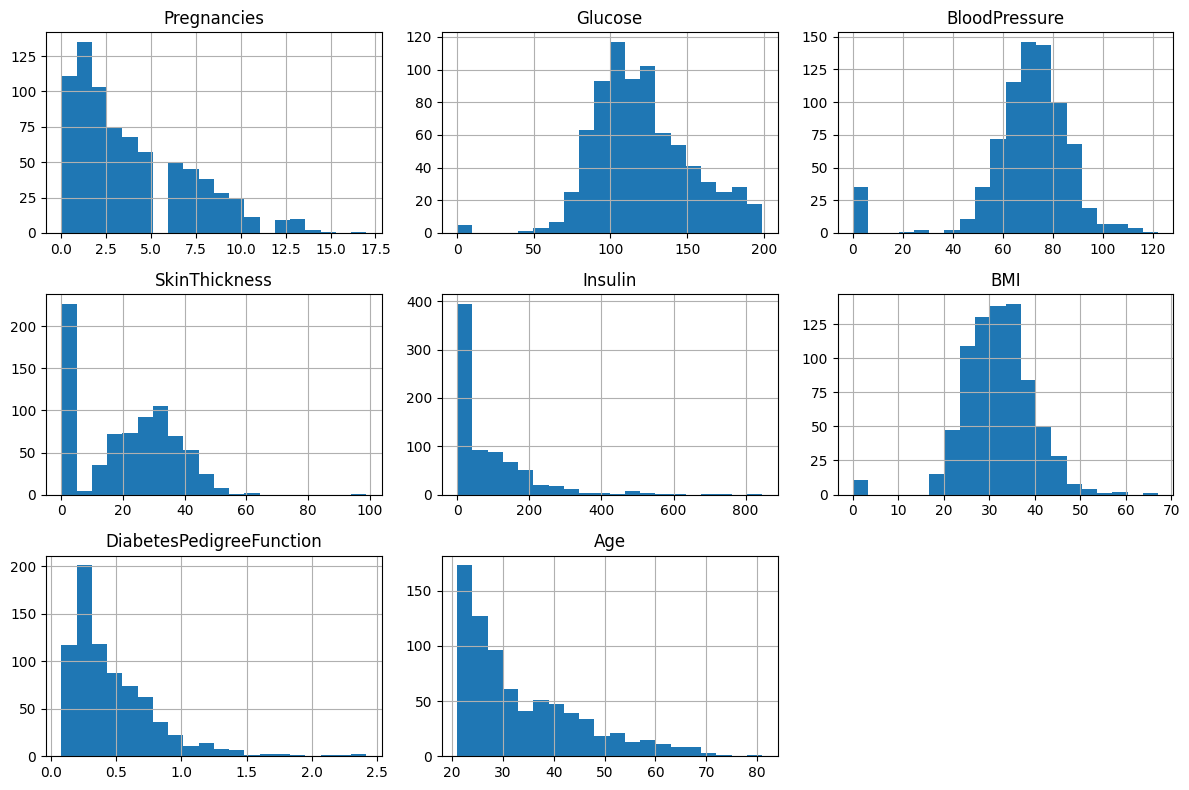

In [16]:
plot_num_summary(df)

# Target Analysis

In [17]:
def target_summary_with_num(dataframe, target, numerical_col):
  print(dataframe.groupby(target).agg({numerical_col: "mean"}))
  print("#############################################")

In [18]:
def target_summary_with_num_df(dataframe, target):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in num_cols:
    target_summary_with_num(dataframe, target, col)

In [19]:
target_summary_with_num_df(df, "Outcome")

         Pregnancies
Outcome             
0             3.2980
1             4.8657
#############################################
         Glucose
Outcome         
0       109.9800
1       141.2575
#############################################
         BloodPressure
Outcome               
0              68.1840
1              70.8246
#############################################
         SkinThickness
Outcome               
0              19.6640
1              22.1642
#############################################
         Insulin
Outcome         
0        68.7920
1       100.3358
#############################################
            BMI
Outcome        
0       30.3042
1       35.1425
#############################################
         DiabetesPedigreeFunction
Outcome                          
0                          0.4297
1                          0.5505
#############################################
            Age
Outcome        
0       31.1900
1       37.0672
##########

# Correlation Analysis

In [20]:
def correlated_cols(dataframe, plot=False):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
  corr = dataframe[num_cols].corr()
  print(corr)

  if plot:
    sns.set(rc={'figure.figsize': (14,7)})
    sns.heatmap(corr, cmap='magma', annot=True, fmt=".2f")
    plt.show()

                          Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction     Age  Outcome
Pregnancies                    1.0000   0.1295         0.1413        -0.0817  -0.0735 0.0177                   -0.0335  0.5443   0.2219
Glucose                        0.1295   1.0000         0.1526         0.0573   0.3314 0.2211                    0.1373  0.2635   0.4666
BloodPressure                  0.1413   0.1526         1.0000         0.2074   0.0889 0.2818                    0.0413  0.2395   0.0651
SkinThickness                 -0.0817   0.0573         0.2074         1.0000   0.4368 0.3926                    0.1839 -0.1140   0.0748
Insulin                       -0.0735   0.3314         0.0889         0.4368   1.0000 0.1979                    0.1851 -0.0422   0.1305
BMI                            0.0177   0.2211         0.2818         0.3926   0.1979 1.0000                    0.1406  0.0362   0.2927
DiabetesPedigreeFunction      -0.0335   0.1373  

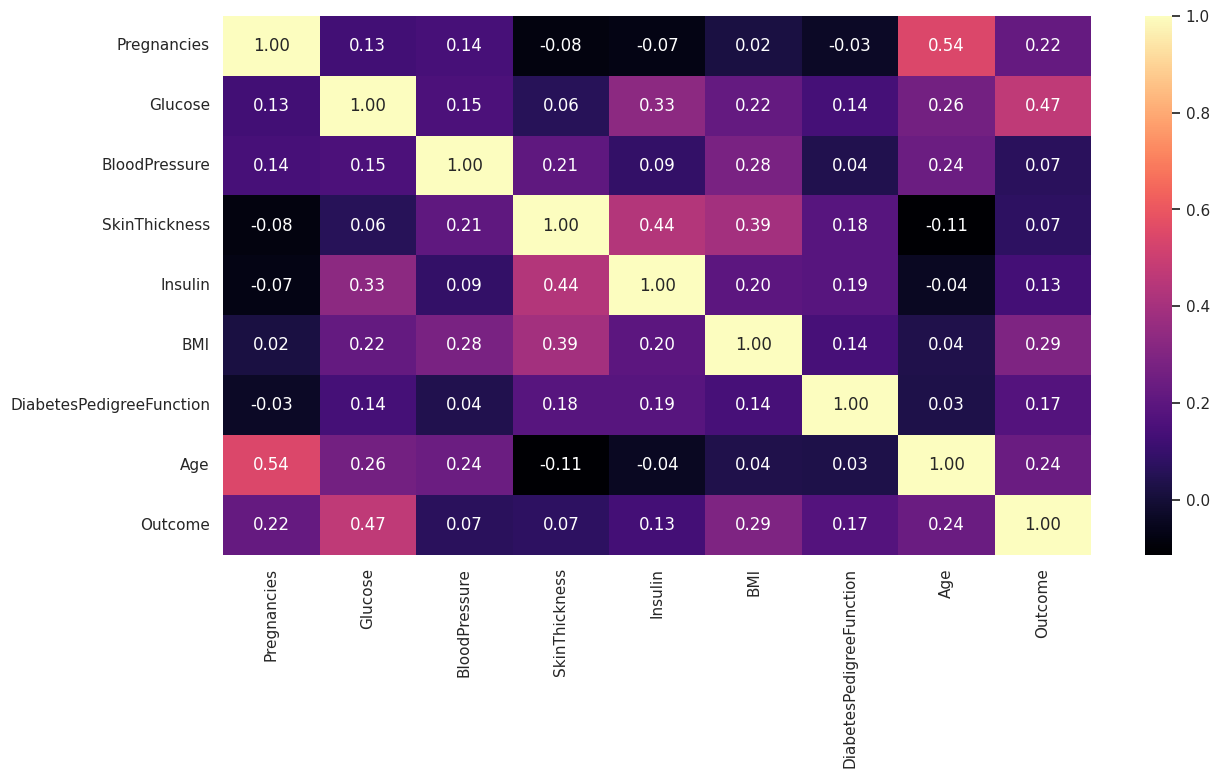

In [21]:
correlated_cols(df, plot=True)

In [22]:
def high_correlated_cols(dataframe, corr_th = 0.90, plot=False):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
  corr = dataframe[num_cols].corr()
  corr_matrix = corr.abs()
  upper_triangular_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  drop_list = [col for col in upper_triangular_matrix.columns if any(upper_triangular_matrix[col] > corr_th)]
  if drop_list == []:
    print("Aftre corelation analysis, we dont need to remove variables")

  if plot:
    sns.set(rc={'figure.figsize': (14,7)})
    sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
    plt.show()

  return drop_list

Aftre corelation analysis, we dont need to remove variables


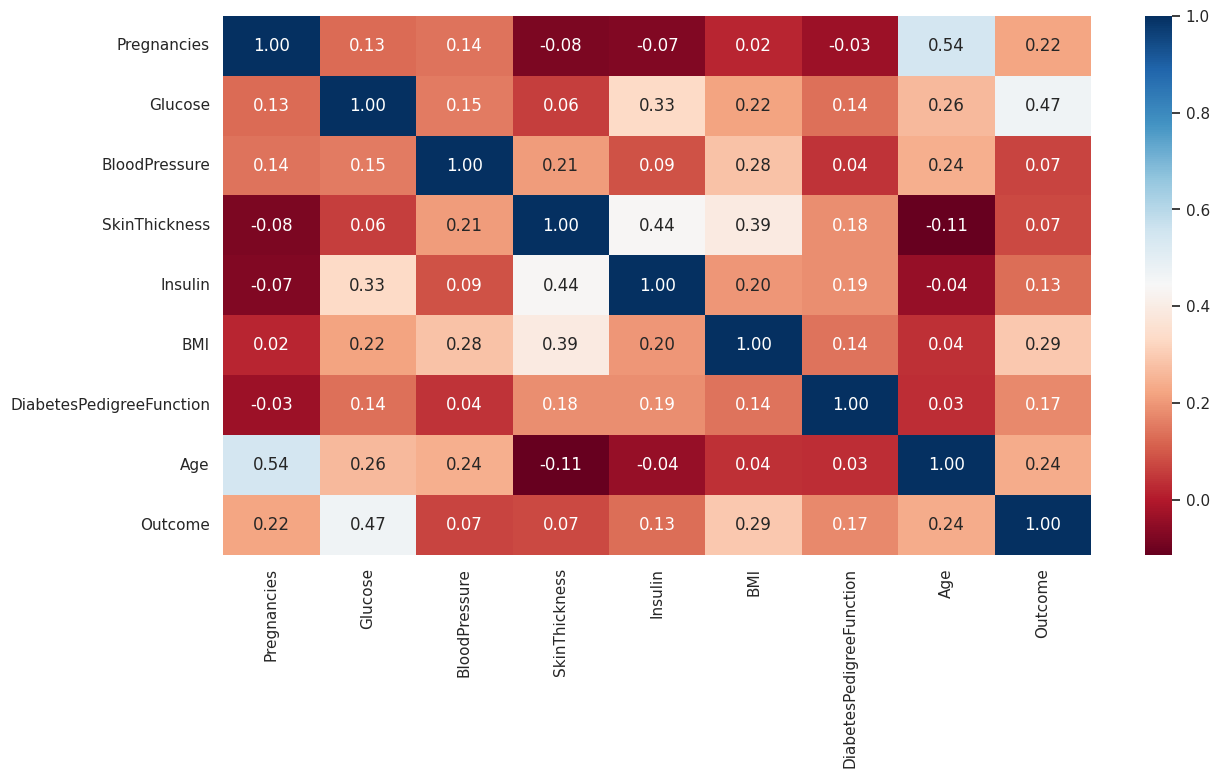

In [23]:
drop_list = high_correlated_cols(df, plot=True)

## Missing Value Analysis

**Not:** It is known that a human cannot have variable values 0 other than Pregnancies and Outcome. Therefore, an action decision should be taken regarding these values. Values that are 0 can be assigned NaN.


In [24]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [25]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
for col in zero_columns:
  df[col] = np.where(df[col]==0, np.nan, df[col])

In [26]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [27]:
def missing_value_table(dataframe, na_names=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=["n_miss", "ratio"])
  print(missing_df)

  if na_names:
    print(25*"#", "NA Columns", 25*"#")
    return na_columns

In [28]:
na_columns = missing_value_table(df, na_names=True)

               n_miss   ratio
Insulin           374 48.7000
SkinThickness     227 29.5600
BloodPressure      35  4.5600
BMI                11  1.4300
Glucose             5  0.6500
######################### NA Columns #########################


In [29]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [30]:
df = fill_na_with_median(df)

In [31]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# Outlier Analysis

In [32]:
def outlier_thresholds(dataframe,col_name,q1=0.05,q3=0.95):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquartile_range = quartile3 - quartile1
  low_limit = quartile1 - 1.5 * interquartile_range
  up_limit = quartile3 + 1.5 * interquartile_range
  return low_limit,up_limit

In [33]:
def check_outlier(dataframe, col_name):
  low_limit,up_limit = outlier_thresholds(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [34]:
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
  dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [35]:
for col in df.columns:
  print(col, check_outlier(df, col))
  if check_outlier(df, col):
    replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [36]:
for col in df.columns:
  print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


# Encoding & Scaling

In [37]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

In [38]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [39]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
for col in binary_cols:
    df = label_encoder(df, col)

In [40]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Outcome"]]
def one_hot_encoding(dataframe, cat_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
    return dataframe

In [41]:
df = one_hot_encoding(df, cat_cols, drop_first=True)

In [42]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0000,72.0000,35.0000,125.0000,33.6000,0.6270,50,1
1,1,85.0000,66.0000,29.0000,125.0000,26.6000,0.3510,31,0
2,8,183.0000,64.0000,29.0000,125.0000,23.3000,0.6720,32,1
3,1,89.0000,66.0000,23.0000,94.0000,28.1000,0.1670,21,0
4,0,137.0000,40.0000,35.0000,168.0000,43.1000,2.2880,33,1


# Support Vector Classifier

**Support Vector Classifier**: Support Vector Classifier (SVC), also known as Support Vector Machine (SVM), is a powerful machine learning algorithm used to solve classification problems. SVC is particularly effective for classifying non-linearly separable datasets and also performs well on high-dimensional datasets. The basic principle of the algorithm is to separate classes from each other by creating a decision boundary that best separates the data points.

# Create a Base Model: SVC

## Linear & RBF Support Vector Classification

In [63]:
def SVC_Model(dataframe, target, kernel, test_size=0.30, cv=5, results=False, conf_matrix=False, c_report=False, roc=False, save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  svc_model = SVC(kernel=kernel, probability=True).fit(X_train, y_train)

  if results:
    acc_train = accuracy_score(y_train, svc_model.predict(X_train))
    acc_test = accuracy_score(y_test, svc_model.predict(X_test))
    r2 = svc_model.score(X, y)
    r2_train = svc_model.score(X_train, y_train)
    r2_test = svc_model.score(X_test, y_test)
    cv_train = cross_val_score(svc_model, X_train, y_train, cv=cv).mean()
    cv_test = cross_val_score(svc_model, X_test, y_test, cv=cv).mean()
    cv_results = cross_validate(svc_model, X, y, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
    print("##################### Accuracy & R2 Metrics ######################")
    print("Accuracy_train: ", "%.3f" % acc_train)
    print("Accuracy_test: ", "%.3f" % acc_test)
    print("R2: ", "%.3f" % r2)
    print("R2_train: ", "%.3f" % r2_train)
    print("R2_test: ", "%.3f" % r2_test)
    print("Cross Validation Score(Train): ", "%.3f" % cv_train)
    print("Cross Validation Score(Test): ", "%.3f" % cv_test)
    print("Cross Validate (Accuracy): ", "%.3f" % cv_results['test_accuracy'].mean())
    print("Cross Validate (Precision): ", "%.3f" % cv_results['test_precision'].mean())
    print("Cross Validate (Recall): ", "%.3f" % cv_results['test_recall'].mean())
    print("Cross Validate (F1): ", "%.3f" % cv_results['test_f1'].mean())
    print("Cross Validate (ROC AUC Score): ", "%.3f" % cv_results['test_roc_auc'].mean())

  if conf_matrix:
    print("##################### Confusion Matrix(Train) ######################")
    print(confusion_matrix(y_train, svc_model.predict(X_train)))
    print("##################### Confusion Matrix(Test) ######################")
    print(confusion_matrix(y_test, svc_model.predict(X_test)))
    print("##################### Confusion Matrix(All) ######################")
    print(confusion_matrix(y, svc_model.predict(X)))
    plt.figure(figsize=(5,5))
    acc = accuracy_score(y, svc_model.predict(X))
    cm = confusion_matrix(y, svc_model.predict(X))
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {}'.format(acc), size=10)
    plt.show()

  if c_report:
    print("###################### Classification Report(Train) ######################")
    print(classification_report(y_train, svc_model.predict(X_train)))
    print("###################### Classification Report(Test) ######################")
    print(classification_report(y_test, svc_model.predict(X_test)))
    print("###################### Classification Report(All) ######################")
    print(classification_report(y, svc_model.predict(X)))

  if roc:
    print("###################### Roc Auc Score(Train) ######################")
    svc_roc_auc_train = roc_auc_score(y_train, svc_model.predict(X_train))
    print("Roc Auc Train: ", "%.3f" % svc_roc_auc_train)
    fpr, tpr, thresholds = roc_curve(y_train, svc_model.predict_proba(X_train)[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label='AUC (area = %.3f)' % svc_roc_auc_train )
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.title('ROC')
    plt.show()

    print("###################### Roc Auc Score(Test) ######################")
    svc_roc_auc_test = roc_auc_score(y_test, svc_model.predict(X_test))
    print("Roc Auc Test: ", "%.3f" % svc_roc_auc_test)
    fpr, tpr, thresholds = roc_curve(y_test, svc_model.predict_proba(X_test)[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label='AUC (area = %.3f)' % svc_roc_auc_test )
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.title('ROC')
    plt.show()

  if save_model:
    joblib.dump(svc_model, "svc_model.pkl")

  return svc_model

##################### Accuracy & R2 Metrics ######################
Accuracy_train:  0.765
Accuracy_test:  0.775
R2:  0.768
R2_train:  0.765
R2_test:  0.775
Cross Validation Score(Train):  0.754
Cross Validation Score(Test):  0.783
Cross Validate (Accuracy):  0.764
Cross Validate (Precision):  0.720
Cross Validate (Recall):  0.537
Cross Validate (F1):  0.614
Cross Validate (ROC AUC Score):  0.838
##################### Confusion Matrix(Train) ######################
[[312  42]
 [ 84  99]]
##################### Confusion Matrix(Test) ######################
[[132  14]
 [ 38  47]]
##################### Confusion Matrix(All) ######################
[[444  56]
 [122 146]]


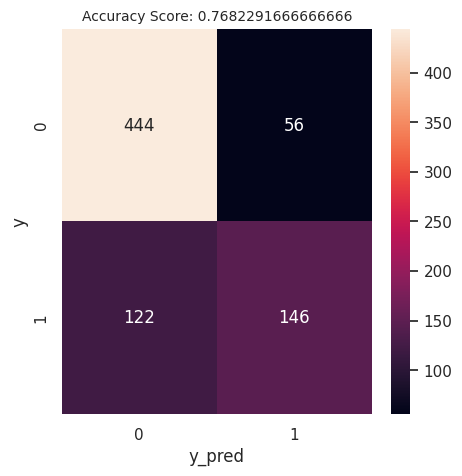

###################### Classification Report(Train) ######################
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       354
           1       0.70      0.54      0.61       183

    accuracy                           0.77       537
   macro avg       0.75      0.71      0.72       537
weighted avg       0.76      0.77      0.76       537

###################### Classification Report(Test) ######################
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       146
           1       0.77      0.55      0.64        85

    accuracy                           0.77       231
   macro avg       0.77      0.73      0.74       231
weighted avg       0.77      0.77      0.76       231

###################### Classification Report(All) ######################
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       500
           1   

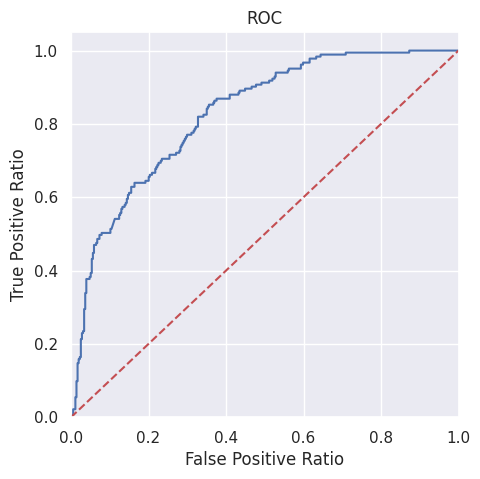

###################### Roc Auc Score(Test) ######################
Roc Auc Test:  0.729


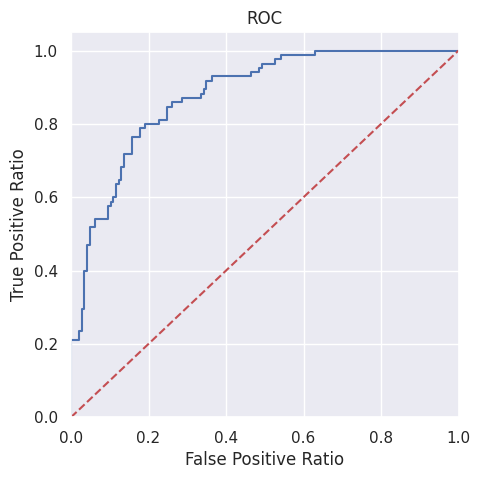

In [64]:
# Linear Support Vector Classification
svc_model = SVC_Model(df, "Outcome", kernel="linear", results=True, conf_matrix=True, c_report=True, roc=True, save_model=True)

##################### Accuracy & R2 Metrics ######################
Accuracy_train:  0.756
Accuracy_test:  0.766
R2:  0.759
R2_train:  0.756
R2_test:  0.766
Cross Validation Score(Train):  0.747
Cross Validation Score(Test):  0.723
Cross Validate (Accuracy):  0.760
Cross Validate (Precision):  0.754
Cross Validate (Recall):  0.478
Cross Validate (F1):  0.581
Cross Validate (ROC AUC Score):  0.819
##################### Confusion Matrix(Train) ######################
[[327  27]
 [104  79]]
##################### Confusion Matrix(Test) ######################
[[138   8]
 [ 46  39]]
##################### Confusion Matrix(All) ######################
[[465  35]
 [150 118]]


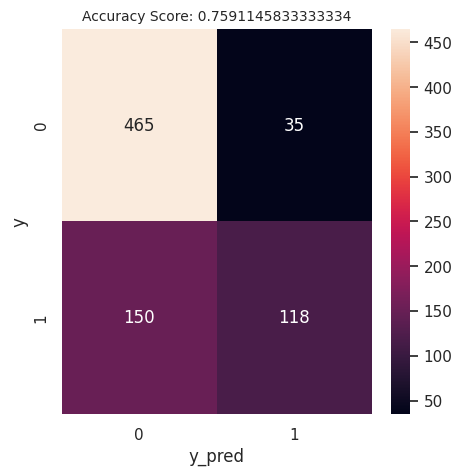

###################### Classification Report(Train) ######################
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       354
           1       0.75      0.43      0.55       183

    accuracy                           0.76       537
   macro avg       0.75      0.68      0.69       537
weighted avg       0.75      0.76      0.74       537

###################### Classification Report(Test) ######################
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       146
           1       0.83      0.46      0.59        85

    accuracy                           0.77       231
   macro avg       0.79      0.70      0.71       231
weighted avg       0.78      0.77      0.75       231

###################### Classification Report(All) ######################
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       500
           1   

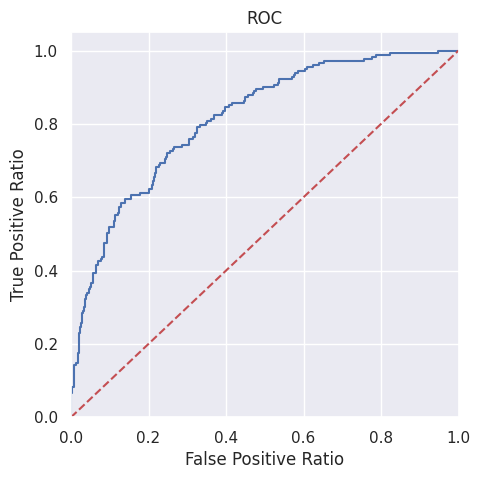

###################### Roc Auc Score(Test) ######################
Roc Auc Test:  0.702


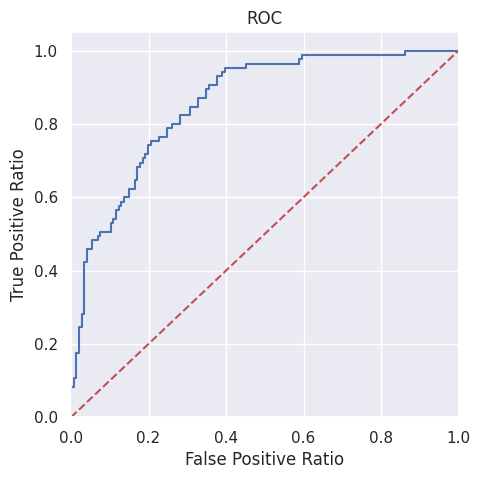

In [65]:
# Non-Linear Support Vector Classification: RBF (Radial Basis Function)
svc_model = SVC_Model(df, "Outcome", kernel="rbf", results=True, conf_matrix=True, c_report=True, roc=True, save_model=True)

##################### Accuracy & R2 Metrics ######################
Accuracy_train:  0.413
Accuracy_test:  0.372
R2:  0.401
R2_train:  0.413
R2_test:  0.372
Cross Validation Score(Train):  0.426
Cross Validation Score(Test):  0.476
Cross Validate (Accuracy):  0.396
Cross Validate (Precision):  0.071
Cross Validate (Recall):  0.060
Cross Validate (F1):  0.064
Cross Validate (ROC AUC Score):  0.221
##################### Confusion Matrix(Train) ######################
[[212 142]
 [173  10]]
##################### Confusion Matrix(Test) ######################
[[82 64]
 [81  4]]
##################### Confusion Matrix(All) ######################
[[294 206]
 [254  14]]


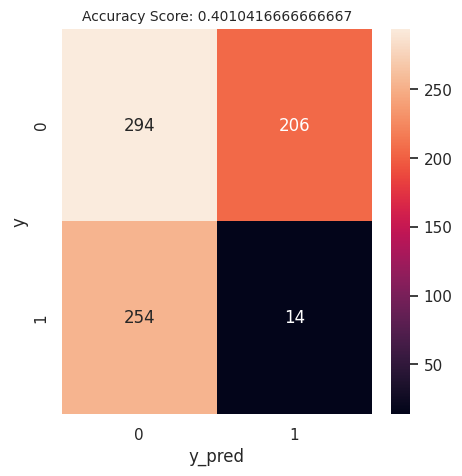

###################### Classification Report(Train) ######################
              precision    recall  f1-score   support

           0       0.55      0.60      0.57       354
           1       0.07      0.05      0.06       183

    accuracy                           0.41       537
   macro avg       0.31      0.33      0.32       537
weighted avg       0.39      0.41      0.40       537

###################### Classification Report(Test) ######################
              precision    recall  f1-score   support

           0       0.50      0.56      0.53       146
           1       0.06      0.05      0.05        85

    accuracy                           0.37       231
   macro avg       0.28      0.30      0.29       231
weighted avg       0.34      0.37      0.35       231

###################### Classification Report(All) ######################
              precision    recall  f1-score   support

           0       0.54      0.59      0.56       500
           1   

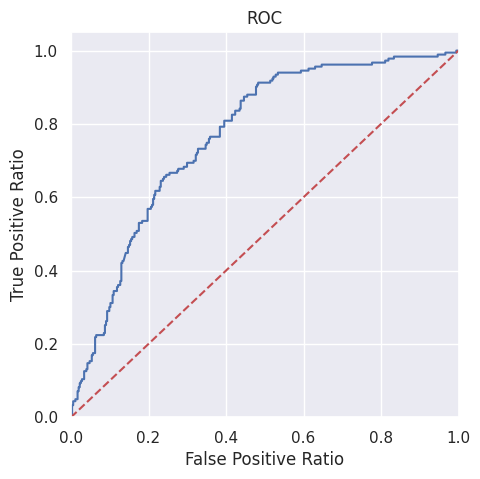

###################### Roc Auc Score(Test) ######################
Roc Auc Test:  0.304


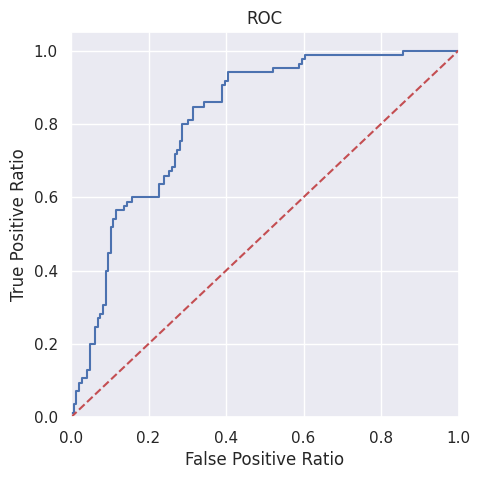

In [91]:
# upport Vector Classification: Sigmoid Kernel
svc_model = SVC_Model(df, "Outcome", kernel="sigmoid", results=True, conf_matrix=True, c_report=True, roc=True, save_model=True)

##################### Accuracy & R2 Metrics ######################
Accuracy_train:  0.754
Accuracy_test:  0.775
R2:  0.760
R2_train:  0.754
R2_test:  0.775
Cross Validation Score(Train):  0.741
Cross Validation Score(Test):  0.762
Cross Validate (Accuracy):  0.758
Cross Validate (Precision):  0.753
Cross Validate (Recall):  0.466
Cross Validate (F1):  0.572
Cross Validate (ROC AUC Score):  0.826
##################### Confusion Matrix(Train) ######################
[[327  27]
 [105  78]]
##################### Confusion Matrix(Test) ######################
[[137   9]
 [ 43  42]]
##################### Confusion Matrix(All) ######################
[[464  36]
 [148 120]]


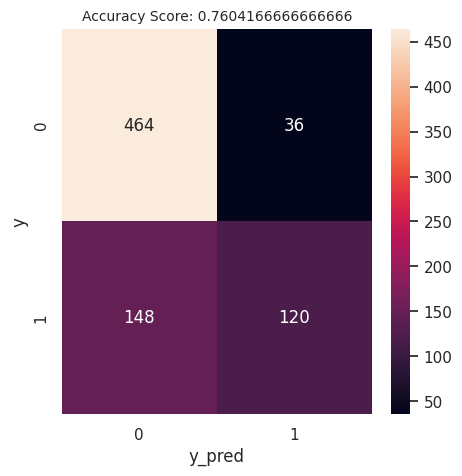

###################### Classification Report(Train) ######################
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       354
           1       0.74      0.43      0.54       183

    accuracy                           0.75       537
   macro avg       0.75      0.67      0.69       537
weighted avg       0.75      0.75      0.73       537

###################### Classification Report(Test) ######################
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       146
           1       0.82      0.49      0.62        85

    accuracy                           0.77       231
   macro avg       0.79      0.72      0.73       231
weighted avg       0.78      0.77      0.76       231

###################### Classification Report(All) ######################
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       500
           1   

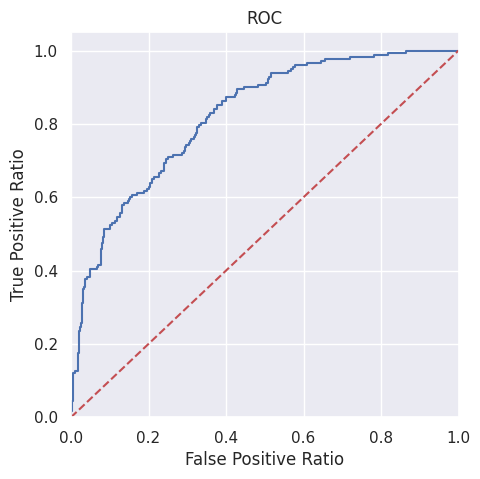

###################### Roc Auc Score(Test) ######################
Roc Auc Test:  0.716


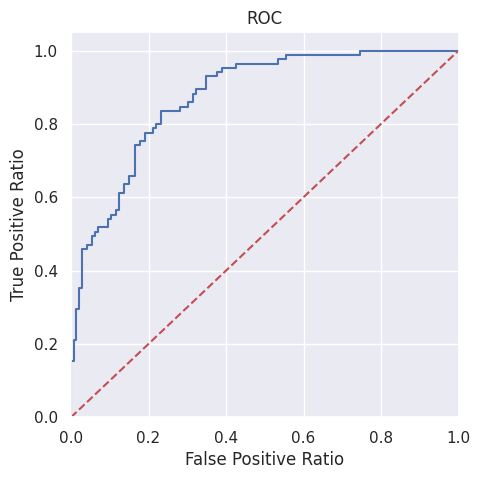

In [92]:
# upport Vector Classification: Polynomial Kernel
svc_model = SVC_Model(df, "Outcome", kernel="poly", results=True, conf_matrix=True, c_report=True, roc=True, save_model=True)

# Loading a SVC Model and Then Prediction

In [66]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [67]:
model_disc = load_model("svc_model.pkl")

In [68]:
patient = [3, 170, 90, 30, 150, 39, 0.72, 65]

In [69]:
model_disc.predict(pd.DataFrame(patient).T)[0]

1

In [70]:
X = df.drop("Outcome", axis=1)
random_patient = X.sample(1)

In [71]:
random_patient

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
8,2,197.0000,70.0000,45.0000,543.0000,30.5000,0.1580,53


In [72]:
model_disc.predict(random_patient)[0]

1

# Create a Model Tuning for Support Vector Classification

In [94]:
def SVC_Model_Tuning(dataframe, target, kernel, test_size=0.30, cv=5, results=False, conf_matrix=False, c_report=False, roc=False, save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  svc_model = SVC(kernel=kernel, probability=True)

  if kernel== "linear":
    svc_params = {'C': np.arange(1,5)}
  elif kernel == "rbf":
    svc_params = {'C': [0.1, 0.01, 0.001, 1, 5, 10, 20],
                  'gamma': [0.1, 0.01, 0.001, 1, 5, 20]}
  else:
    svc_params = {'C': np.arange(1,5)}

  svc_cv_model = GridSearchCV(svc_model, svc_params, cv=cv, verbose=True, n_jobs=-1).fit(X_train, y_train)
  svc_model_tuned = svc_model.set_params(**svc_cv_model.best_params_).fit(X, y)

  if results:
    acc_train = accuracy_score(y_train, svc_model_tuned.predict(X_train))
    acc_test = accuracy_score(y_test, svc_model_tuned.predict(X_test))
    r2 = svc_model.score(X, y)
    r2_train = svc_model_tuned.score(X_train, y_train)
    r2_test = svc_model_tuned.score(X_test, y_test)
    cv_train = cross_val_score(svc_model_tuned, X_train, y_train, cv=cv).mean()
    cv_test = cross_val_score(svc_model_tuned, X_test, y_test, cv=cv).mean()
    cv_results = cross_validate(svc_model_tuned, X, y, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
    print("##################### Accuracy & R2 Metrics ######################")
    print(f"SVC Best Params {kernel}: {svc_cv_model.best_params_}")
    print("Accuracy_train: ", "%.3f" % acc_train)
    print("Accuracy_test: ", "%.3f" % acc_test)
    print("R2: ", "%.3f" % r2)
    print("R2_train: ", "%.3f" % r2_train)
    print("R2_test: ", "%.3f" % r2_test)
    print("Cross Validation Score(Train): ", "%.3f" % cv_train)
    print("Cross Validation Score(Test): ", "%.3f" % cv_test)
    print("Cross Validate (Accuracy): ", "%.3f" % cv_results['test_accuracy'].mean())
    print("Cross Validate (Precision): ", "%.3f" % cv_results['test_precision'].mean())
    print("Cross Validate (Recall): ", "%.3f" % cv_results['test_recall'].mean())
    print("Cross Validate (F1): ", "%.3f" % cv_results['test_f1'].mean())
    print("Cross Validate (ROC AUC Score): ", "%.3f" % cv_results['test_roc_auc'].mean())

  if conf_matrix:
    print("##################### Confusion Matrix(Train) ######################")
    print(confusion_matrix(y_train, svc_model_tuned.predict(X_train)))
    print("##################### Confusion Matrix(Test) ######################")
    print(confusion_matrix(y_test, svc_model_tuned.predict(X_test)))
    print("##################### Confusion Matrix(All) ######################")
    print(confusion_matrix(y, svc_model_tuned.predict(X)))
    plt.figure(figsize=(5,5))
    acc = accuracy_score(y, svc_model_tuned.predict(X))
    cm = confusion_matrix(y, svc_model_tuned.predict(X))
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {}'.format(acc), size=10)
    plt.show()

  if c_report:
    print("###################### Classification Report(Train) ######################")
    print(classification_report(y_train, svc_model_tuned.predict(X_train)))
    print("###################### Classification Report(Test) ######################")
    print(classification_report(y_test, svc_model_tuned.predict(X_test)))
    print("###################### Classification Report(All) ######################")
    print(classification_report(y, svc_model_tuned.predict(X)))

  if roc:
    print("###################### Roc Auc Score(Train) ######################")
    svc_roc_auc_train = roc_auc_score(y_train, svc_model_tuned.predict(X_train))
    print("Roc Auc Train: ", "%.3f" % svc_roc_auc_train)
    fpr, tpr, thresholds = roc_curve(y_train, svc_model_tuned.predict_proba(X_train)[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label='AUC (area = %.3f)' % svc_roc_auc_train )
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.title('ROC')
    plt.show()

    print("###################### Roc Auc Score(Test) ######################")
    svc_roc_auc_test = roc_auc_score(y_test, svc_model_tuned.predict(X_test))
    print("Roc Auc Test: ", "%.3f" % svc_roc_auc_test)
    fpr, tpr, thresholds = roc_curve(y_test, svc_model_tuned.predict_proba(X_test)[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label='AUC (area = %.3f)' % svc_roc_auc_test )
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.title('ROC')
    plt.show()

  if save_model:
    joblib.dump(svc_model_tuned, "svc_model_tuned.pkl")

  return svc_model_tuned

Fitting 5 folds for each of 4 candidates, totalling 20 fits
##################### Accuracy & R2 Metrics ######################
SVC Best Params linear: {'C': 3}
Accuracy_train:  0.764
Accuracy_test:  0.784
R2:  0.770
R2_train:  0.764
R2_test:  0.784
Cross Validation Score(Train):  0.756
Cross Validation Score(Test):  0.783
Cross Validate (Accuracy):  0.766
Cross Validate (Precision):  0.724
Cross Validate (Recall):  0.537
Cross Validate (F1):  0.615
Cross Validate (ROC AUC Score):  0.837
##################### Confusion Matrix(Train) ######################
[[313  41]
 [ 86  97]]
##################### Confusion Matrix(Test) ######################
[[132  14]
 [ 36  49]]
##################### Confusion Matrix(All) ######################
[[445  55]
 [122 146]]


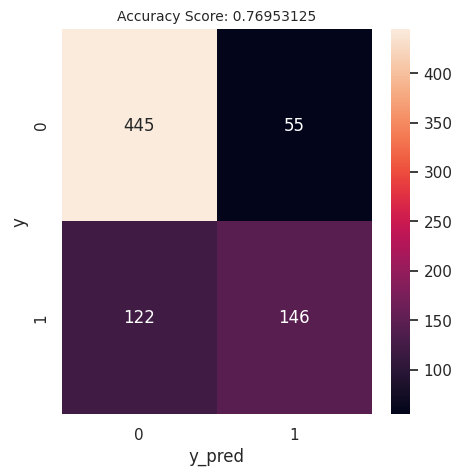

###################### Classification Report(Train) ######################
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       354
           1       0.70      0.53      0.60       183

    accuracy                           0.76       537
   macro avg       0.74      0.71      0.72       537
weighted avg       0.76      0.76      0.75       537

###################### Classification Report(Test) ######################
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       146
           1       0.78      0.58      0.66        85

    accuracy                           0.78       231
   macro avg       0.78      0.74      0.75       231
weighted avg       0.78      0.78      0.78       231

###################### Classification Report(All) ######################
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       500
           1   

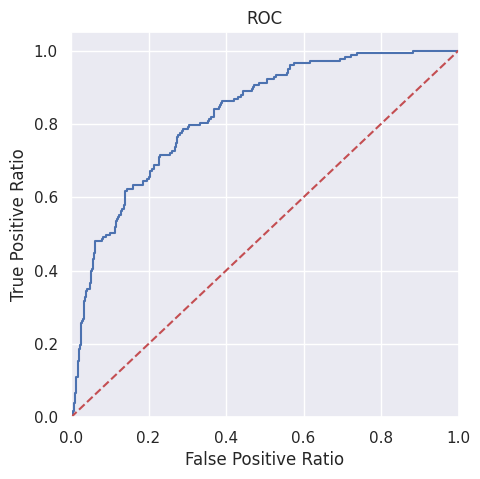

###################### Roc Auc Score(Test) ######################
Roc Auc Test:  0.740


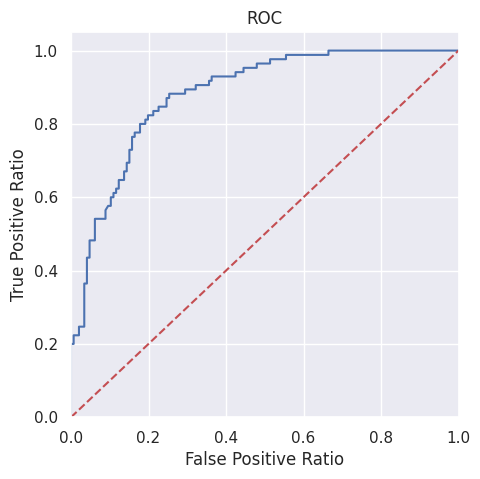

In [95]:
svc_model_tuned = SVC_Model_Tuning(df, "Outcome", kernel="linear", results=True, conf_matrix=True, c_report=True, roc=True, save_model=True)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
##################### Accuracy & R2 Metrics ######################
SVC Best Params rbf: {'C': 1, 'gamma': 0.001}
Accuracy_train:  0.832
Accuracy_test:  0.844
R2:  0.836
R2_train:  0.832
R2_test:  0.844
Cross Validation Score(Train):  0.730
Cross Validation Score(Test):  0.684
Cross Validate (Accuracy):  0.738
Cross Validate (Precision):  0.686
Cross Validate (Recall):  0.481
Cross Validate (F1):  0.561
Cross Validate (ROC AUC Score):  0.792
##################### Confusion Matrix(Train) ######################
[[331  23]
 [ 67 116]]
##################### Confusion Matrix(Test) ######################
[[138   8]
 [ 28  57]]
##################### Confusion Matrix(All) ######################
[[469  31]
 [ 95 173]]


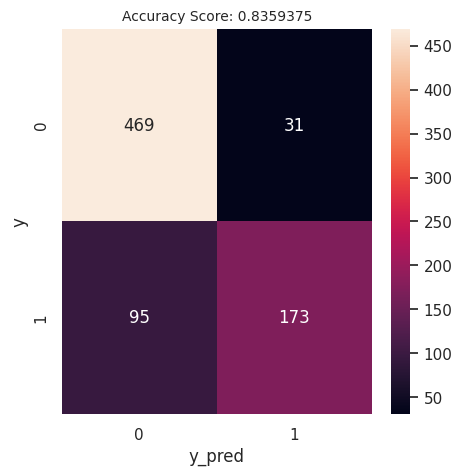

###################### Classification Report(Train) ######################
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       354
           1       0.83      0.63      0.72       183

    accuracy                           0.83       537
   macro avg       0.83      0.78      0.80       537
weighted avg       0.83      0.83      0.83       537

###################### Classification Report(Test) ######################
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       146
           1       0.88      0.67      0.76        85

    accuracy                           0.84       231
   macro avg       0.85      0.81      0.82       231
weighted avg       0.85      0.84      0.84       231

###################### Classification Report(All) ######################
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       500
           1   

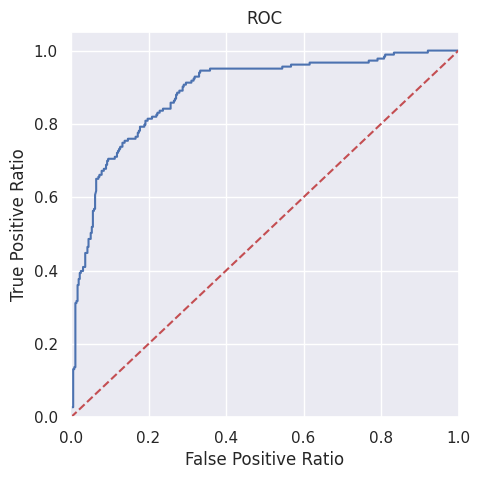

###################### Roc Auc Score(Test) ######################
Roc Auc Test:  0.808


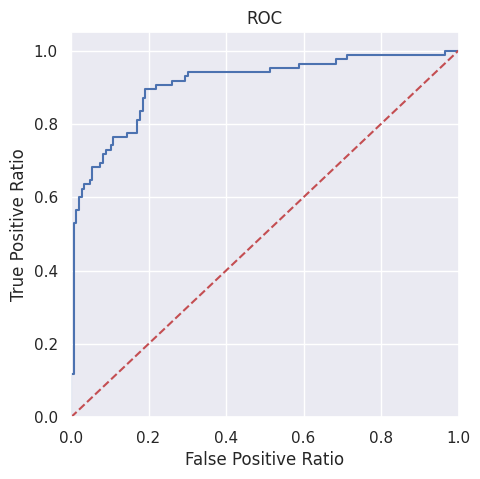

In [96]:
# Non-Linear Support Vector Classifier Tuned: RBF
svc_model_tuned = SVC_Model_Tuning(df, "Outcome", kernel="rbf", results=True, conf_matrix=True, c_report=True, roc=True, save_model=True)

# Loading a SVC Tuned Model and Then Prediction

In [97]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [98]:
model_disc = load_model("svc_model_tuned.pkl")

In [99]:
patient = [3, 170, 90, 30, 150, 39, 0.72, 65]

In [100]:
model_disc.predict(pd.DataFrame(patient).T)[0]

1

In [101]:
X = df.drop("Outcome", axis=1)
random_patient = X.sample(1)

In [102]:
random_patient

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
434,1,90.0000,68.0000,8.0000,125.0000,24.5000,1.1380,36


In [103]:
model_disc.predict(random_patient)[0]

0